# HW2 - Bayesian Inference in the Poisson Generalized Linear Model

**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Jake Taylor

**Names of any collaborators:** None

*Due: 11:59pm Friday, April 16, 2021 via GradeScope*

---

In this 2nd homework, we will perform Bayesian Inference in the Poisson generalized linear model.

**References:**
- Chapter 16 of BDA3 contains background material on generalized linear models.
- Chapter 7.1 of BDA3 introduces notation for model evaluation based on predictive log likelihoods.
- The data we use comes from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long). If you're interested, see `README.txt` file in the `/data_RGCs` directory or the [Pillow  tutorial](https://github.com/pillowlab/GLMspiketraintutorial/blob/master/python/tutorial1_PoissonGLM.ipynb) for details.


**Remark:** While some programming languages may incorporate packages that fit Poisson GLMs using one line of code, deriving some of the calculations yourself is an important part of this assignment. Therefore, calls to specialized GLM libraries such as pyglmnet are **prohibited**. Of course, standard libraries such as Numpy are still allowed (and encouraged!). calls to numerical optimizers (such as scipy.optimize.minimize) are fair game. 



## The Poisson GLM
The Poisson distribution is a common model for count data with a single parameter $\lambda \in \mathbb{R}_+$. Its pmf is,
\begin{align}
\Pr(y \mid \lambda) &= \frac{1}{y!} e^{-\lambda} \lambda^y,
\end{align}
for $y \in \mathbb{N}$. Its mean and variance are both equal to $\lambda$.

Suppose we have count observations $y_n \in \mathbb{N}$ along with covariates $x_n \in \mathbb{R}^P$. We construct a Poisson GLM by modeling the expected value as,
\begin{align}
\mathbb{E}[y_n \mid x_n] = f(w^\top x_n),
\end{align}
with $w \in \mathbb{R}^P$ and $f: \mathbb{R} \to \mathbb{R}_+$ is the mean function. The _canonical mean function_ is $f(a) = e^a$; equivalently, the canonical _link_ function is the logarithm.


We assume a Gaussian prior on the weights $w$:
$$
w \sim \mathcal{N}(0, \sigma^2 I),
$$

where $\sigma^2 I$ is the covariance matrix.

## Load the data

The data consists of spike counts from a retinal neuron responding to a flickering light. The spike counts are measured in 8.3ms bins and they range from 0 to 3 spikes/bin. The stimulus is binary, either .48 if the light is on or -.48 if it's off. The goal of this assignment is to model how the neural spike counts relate to recent light exposure over the past 25 time bins (approximately 200ms).

We've provided some code to load the data in Python and plot it. Feel free to convert this to R if that is your preference.

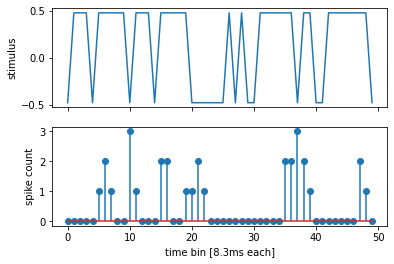

In [1]:
!wget -nc -q https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw2/hw2.csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("hw2.csv")

# Convert the training data to arrays
y_train = np.array(df["y_train"])
stim_train = np.array(df["stim_train"])
N_train = len(y_train)

# Convert the test data to arrays
y_test = np.array(df["y_test"])
stim_test = np.array(df["stim_test"])
N_test = len(y_test)

# Plot the stimulus and spike counts
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(stim_train[:50])
axs[0].set_ylabel("stimulus")
axs[1].stem(y_train[:50], use_line_collection=True)
axs[1].set_ylabel('spike count')
_ = axs[1].set_xlabel('time bin [8.3ms each]')

$\pagebreak$

## Problem 1: Construct the design matrix

Let $y_n \in \mathbb{N}$ denote the spike count in the $n$-th time bin and  $s_n \in \mathbb{R}$ denote the corresponding stimulus at that bin.

Construct the _design matrix_ for the training data $X \in \mathbb{R}^{N_{\mathsf{train}} \times P}$ with rows
\begin{align}
x_n &= (1, s_n, s_{n-1}, \ldots, s_{n-L+1})
\end{align}
where $L=25$ denotes the number of stimulus bins to include in the covariates. (Thus the number of total covariates is $P=L+1$.)

Visualize the first 50 rows of the matrix with, e.g., `imshow`. Don't forget your labels and colorbar.

_Note: Pad the stimulus with zeros so that $s_i = 0$ for $i\leq 0$._

In [2]:
L = 25
padded = np.pad(stim_train, (L-1, 0), 'constant', constant_values=(0, 0))
X = np.lib.stride_tricks.sliding_window_view(padded, 25)
X = np.flip(X, axis=1)
X = np.pad(X, ((0, 0), (1, 0)), 'constant', constant_values = 1)
X

array([[ 1.  , -0.48,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.48, -0.48, ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.48,  0.48, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.  , -0.48, -0.48, ..., -0.48,  0.48,  0.48],
       [ 1.  ,  0.48, -0.48, ..., -0.48, -0.48,  0.48],
       [ 1.  ,  0.48,  0.48, ..., -0.48, -0.48, -0.48]])

In [3]:
X.shape

(1000, 26)

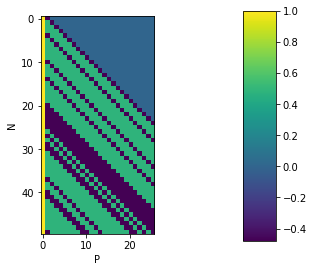

In [4]:
plt.imshow(X[:50,])
plt.xlabel('P')
plt.ylabel('N')
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

$\pagebreak$

## Problem 2a [Math]: Derive the log joint probability
Derive the log joint probability, 
\begin{align}
\mathcal{L}(w) &\triangleq \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2)
\end{align}

\begin{gather*}
p(\{y_n\}_{n=1}^N, \vec w | \{\vec x_n\}_{n=1}^N, \sigma^2) \stackrel{\perp}{=} \prod_{i = 1}^n p(y_i, \vec w | \vec x_i, \sigma^2) \\
\prod_{i = 1}^n \frac{p(y_i, \vec w, \vec x_i, \sigma^2)}{p(\vec x_i, \sigma^2)} \\
=\prod_{i = 1}^n \frac{p(y_i | \vec w, \vec x_i, \sigma^2) p(\vec w, \vec x_i, \sigma^2)}{p(\vec x_i, \sigma^2)}\\
\propto \prod_{i = 1}^n p(y_i | \vec w, \vec x_i)p(\vec w| \sigma^2)\\
\therefore \mathcal L(\vec w) \propto \sum_{i=1}^N \log p(y_i|\vec w, \vec x_i) + \log p(\vec w| \sigma^2)\\
= \sum_{i=1}^N -\log y_i! - \exp(\vec w^T \vec x_i)) + y_i\cdot(\vec w^T \vec x_i) -\frac{d}{2}\log 2\pi - \frac{1}{2} \log |\sigma^2 I_n| - \frac{1}{2\sigma^2}\vec w^T I_n\vec w
\end{gather*}
And dropping all terms not dependent on $\vec w$,
\begin{gather*}
=\sum_{i=1}^N y_i\cdot(\vec w^T \vec x_i) - \exp(\vec w^T \vec x_i))- \frac{1}{2\sigma^2}\vec w^T\vec w
\end{gather*}

$\pagebreak$


## Problem 2b [Code]: Implement the log probability function
Write a function that computes the log joint probability and evaluate it on the training set with $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

In [5]:
w0 = np.zeros_like(X[0,:])
    
def log_prob(w, X, y, sigma2=1):
    N, p = X.shape
    return np.sum((y * X.dot(w)) - np.exp(X.dot(w))) - (1 / 2*sigma2) * w.T.dot(w)

log_prob(w0, X, y_train)

-1000.0

$\pagebreak$


## Problem 3a [Math]: Derive the gradient
Derive the gradient of the log joint probability
\begin{align}
\nabla_w \mathcal{L}(w) &= \ldots
\end{align}
\begin{gather*}
 = \frac{\partial}{\partial \vec w} \sum_N y_i(\vec w^T \vec x_i) - \exp(\vec w^T \vec x_i) - \frac{1}{2\sigma^2}\vec w^T \vec w \\
 = \sum_N y_i \vec x_i -  \exp(\vec w^T \vec x_i)\vec x_i - \frac{1}{\sigma^2} \vec w \\
 = \sum_N x_i(y_i - \exp(\vec w^T \vec x_i)) - \frac{1}{\sigma^2} \vec w 
\end{gather*}

$\pagebreak$


## Problem 3b [Code]: Implement the gradient

Write a function to compute the gradient wrt $w$ of the log probability for given values of $w$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

**Note:**  While this is not required in this homework, it may be helpful to do numerical checks for gradient and Hessian calculations using finite differences.  See *e.g.* Section 4.2 of https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf.


 

In [6]:
w0 = np.zeros_like(X[0,:])

def gradient(w, X, y, sigma2=1):
    N, p = X.shape
    return np.sum(X * (y_train - np.exp(X.dot(w))).reshape(N, 1), axis=0) - (1/sigma2) * w

gradient(w0, X, y_train)

array([-603.  ,    7.2 ,   18.24,   44.64,  119.04,  145.44,   64.32,
        -51.84,  -59.04,  -44.64,  -44.16,  -47.52,  -54.24,  -33.12,
        -27.84,  -50.4 ,  -48.  ,  -34.08,  -50.88,  -38.88,  -22.08,
        -37.44,  -29.76,  -11.04,    2.4 ,    1.92])

$\pagebreak$

## Problem 4a [Math]: Derive the Hessian
Derive the Hessian of the log joint probability
\begin{align}
\nabla^2_w \mathcal{L}(w) &= \ldots
\end{align}
\begin{gather*}
\frac{\partial^2 \mathcal L(w)}{\partial \vec w_m \partial \vec w_l}= -\sum_{i=1}^N \vec x_{i,m} \vec x_{i,l}\exp(\vec w^T \vec x_i) \\
= -X^TWX \\
W = diag(\exp(X\vec w))
\end{gather*}

$\pagebreak$


## Problem 4b [Code]: Implement the Hessian

Write a function to compute the Hessian of the log probability for given values of $w$ and $\sigma^2$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. 

Visualize the Hessian with, e.g., `imshow`. Don't forget labels and a colorbar.

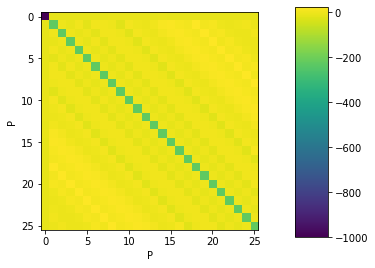

In [7]:
w0 = np.zeros_like(X[0,:])

def hessian(w, X=X):
    return -X.T.dot(np.diag(np.exp(X.dot(w)))).dot(X)

res = hessian(w0)
plt.imshow(res)
plt.xlabel('P')
plt.ylabel('P')
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

$\pagebreak$


## Problem 5: Compute the Laplace approximation

This problem has two parts. See below.

## Problem 5a: Optimize to find the posterior mode
Optimize the log joint probability to find the posterior mode. You may use built-in optimization libraries (e.g. `scipy.optimize.minimize`).

In [8]:
from scipy.optimize import minimize

def neg_log_prob(w):
    return -log_prob(w, X=X, y=y_train, sigma2=1)

def neg_gradient(w):
    return -gradient(w, X=X, y=y_train, sigma2=1)

w0 = np.zeros_like(X[0,:])

res = minimize(fun=neg_log_prob,
               x0=w0,
               method='BFGS',
               jac=neg_gradient,
               options={'disp':True}
              )

Optimization terminated successfully.
         Current function value: 409.069536
         Iterations: 45
         Function evaluations: 62
         Gradient evaluations: 62


In [9]:
res.x

array([-1.98387933,  0.0191608 ,  0.13772387,  0.44424198,  1.54388212,
        2.25596675,  0.73980468, -0.53345777, -0.52035011, -0.45324568,
       -0.41421397, -0.24945071, -0.47640201, -0.32471356, -0.14218618,
       -0.26219343, -0.19492631, -0.06752138, -0.13640138, -0.02965947,
        0.1381938 , -0.0641458 ,  0.03259869, -0.01427327, -0.01652948,
       -0.05321329])

$\pagebreak$


## Problem 5b: Approximate the covariance at the mode

Solve for $\Sigma_{\mathsf{MAP}} = -[\nabla^2(\mathcal{L}(w_{\mathsf{MAP}})]^{-1}$. Plot the covariance matrix (e.g. with `imshow`). Don't forget to add a colorbar and labels.

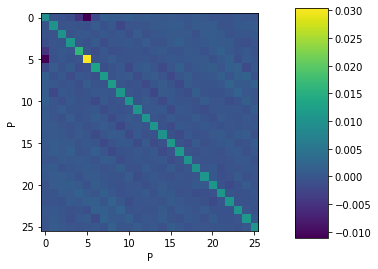

In [10]:
plt.imshow(res.hess_inv)
plt.xlabel('P')
plt.ylabel('P')
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

$\pagebreak$

## Problem 6: Plot the posterior of the weights
Plot the posterior mean of the weights for features $s_n, \ldots, s_{n-L+1}$ (i.e. not including the bias term). Also plot 95% credible intervals around the mean by using two standard deviations of the marginal distribution of the weights. Note the diagonal of $\Sigma_{\mathsf{MAP}}$ gives the marginal variance of the posterior. 

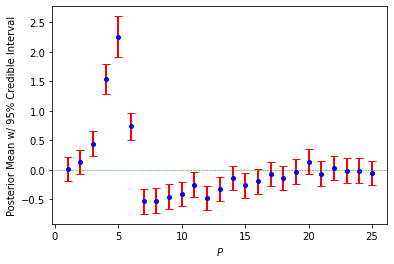

In [11]:
w_map = res.x[1:]
sd = np.sqrt(np.diag(res.hess_inv))[1:]
plt.axhline(0, linestyle='--', color='g', linewidth=.5)
plt.errorbar(x=np.arange(1, 26),
             y=w_map,
             yerr=2*sd, # assumes symmetric errors 
             markersize=8,
             linewidth=2,
             fmt='b.',
             ecolor='r',
             capsize=4,
             )
plt.xlabel(r'$P$')
plt.ylabel('Posterior Mean w/ 95% Credible Interval')
plt.show()

$\pagebreak$

## Problem 7 [Short Answer]: Interpret your results

Here, the neurons are cells from the retina, which are responsive to light. The stimulus at time bin $n$ is either -0.5 or +0.5 depending on whether a light was off or on, respectively, at that time. What do these weights tell you about the relationship between the stimulus and the spike counts? 

_Answer below this line_  

---
The weights observed in Problem (6) show that the response (spike count) has a signficant relationship with lagged covariates (stimlus) that happened between 3-13 bins in the past (5 is on the brink of significance). Lags 3-6 have a positive relationship with the response and lags 7-13 have a negative relationship. Lagged covariates at all other time lags  include $\vec w_i=0$ in their 95% credible intervals making them insignificant. So at first, the spike counts go up with recent observations (3-6) and then are negatively correlated with more distant lags (7-13) until there is no affect at all (13-25).

$\pagebreak$


## Problem 8: Approximate the posterior predictive distribution of the rates

Draw many samples $w^{(s)}$ from the Laplace approximation of the posterior $p(w \mid \{x_n, y_n\})$.  Use those samples to approximate the posterior predictive distribution on the **test** dataset,
\begin{align}
p(y_{n'}=k \mid x_{n'}, \{x_n, y_n\}_{n=1}^N) &= 
\int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}

Visualize the posterior predictive distribution as an $K \times N_{\mathsf{test}}$ array where row corresponds to possible spike counts $k\in \{0,\ldots, K\}$. You can set $K=5$ for this problem. **Only show the first 100 columns (time bins), otherwise it's hard to see changes in the rate.**

Overlay the actual spike counts for the test dataset. 

In [12]:
L = 25
padded = np.pad(stim_test, (L-1, 0), 'constant', constant_values=(0, 0))
X_test = np.lib.stride_tricks.sliding_window_view(padded, 25)
X_test = np.flip(X_test, axis=1)
X_test = np.pad(X_test, ((0, 0), (1, 0)), 'constant', constant_values = 1)
N, P = X_test.shape
N, P

(1000, 26)

In [13]:
from scipy.stats import poisson
S=1000
K=5
W = np.random.multivariate_normal(res.x, res.hess_inv, S)
rate = np.exp(X_test.dot(W.T))
post_pred_dist = np.array([np.mean(poisson.pmf(i, rate), axis = 1) for i in range(0, K+1)])
post_pred_dist.shape

(6, 1000)

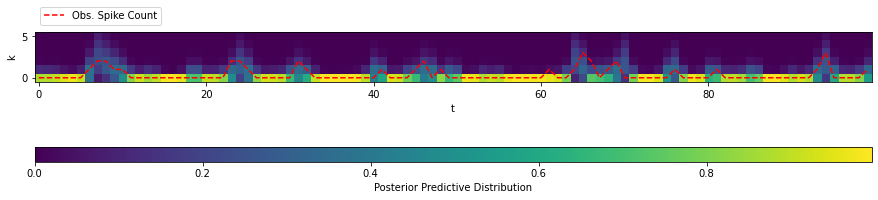

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
T_MAX = 100
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(15)
plt.imshow(post_pred_dist[:, 0:T_MAX])
plt.xlabel('t')
plt.ylabel('k')
plt.plot(y_test[0:T_MAX], 'r--', label='Obs. Spike Count')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.6))
plt.gca().invert_yaxis()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="30%", pad=.9)
plt.colorbar(cax=cax, label='Posterior Predictive Distribution', orientation='horizontal')
plt.show()

$\pagebreak$

## Problem 9: Compute the log predictive density

Simulate from the posterior distribution to compute a Monte Carlo approximation to what the book calls the _log pointwise predictive density_ (Eq. 7.4). 
\begin{align}
\sum_{n'=1}^{N_{\mathsf{test}}} \log p(y_{n'} \mid x_{n'}, \{x_n, y_n\}_{n=1}^N ) 
&= 
\sum_{n'=1}^{N_{\mathsf{test}}} \log \int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \sum_{n'=1}^{N_{\mathsf{test}}} \log \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N) \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}
Use $S=1000$ Monte Carlo samples and **print your result**.

_Note_: The book recommends a more fully Bayesian approach in which they compute the log pointwise predictive density for one data point at a time, using the remainder to compute the posterior distribution on the weights. For simplicity, we will stick with a single training and test split, as given in the dataset above.

In [18]:
# Is this done over k={0,..., 5} as well?
np.sum(np.log(post_pred_dist), axis=1)

array([  -345.14110575,  -2338.01375532,  -4948.39473621,  -7889.08711171,
       -11042.78028476, -14345.58870144])

In [19]:
np.sum(np.log(np.mean(poisson.pmf(y_test, rate), axis = 1)))

-572.5979433540954

$\pagebreak$


## Submission Instructions
**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set Tools → Settings → Editor → Vertical ruler column to 80 to see when you've exceeded the limit.

Download your notebook in .ipynb format and use the following commands to convert it to PDF:

jupyter nbconvert --to pdf hw2_yourname.ipynb

**Dependencies:**

nbconvert: If you're using Anaconda for package management,
conda install -c anaconda nbconvert

**Upload** your .ipynb and .pdf files to Gradescope.